# 3. Business Intelligence on Gartner IT Symposium Xpo 2020 Session Speakers

This notebook uses session data from Gartner IT Symposium Xpo 2020 sessions to investigate a number of questions regarding the speakers at Gartner IT Symposium Xpo 2020. 

The data is loaded from our local data warehouse - the file `gartner-it-synmposium-xpo-2020-sessions-wrangled.json` that is produced by the notebook <a href="./2-Gartner IT Symposium Xpo 2020 Session Catalog - Wrangling I - one single, refined, reshaped file.ipynb">2-Gartner IT Symposium Xpo 2020 Session Catalog - Wrangling I - one single, refined, reshaped file.ipynb</a>. 

In this single, consolidated file with session records, the following features are readily available for each session:
<table><tr>
    <td>code</td><td>title</td><td>room</td>
    </tr><tr>
    
    <tr>
    <td>slides_uploaded_yn</td><td>day</td><td>time</td>
    </tr>
    <tr>
    <td>number_of_speakers</td><td>speaker name</td><td>speaker job title</td>
    </tr>
    <tr>
    <td>speaker_company</td><td></td>
    </tr>
    <tr>
    <td></td><td>length of session</td><td>session type</td>
    </tr>
    </table>

Some of the questions explored with this notebook:

* <a href="#counting">how many speakers contributed to the Gartner IT Symposium?</a>
* <a href="#mostactive">which speakers contributed to the largest number of sessions (most active speakers)</a>
* <a href="#jobtitle">what do speakers do in their regular day job: what are the job titles of the speakers?</a>
* <a href="#company">for which companies are speakers working? How important is the role of Gartner (speakers) in the conference?</a>  
* <a href="#names">what are the most popular first names of these speakers?</a>
* <a href="#gender">what is the gender distribution among these speakers? is this distribution different in different tracks or for different levels?</a> 

### <a href="#bonus">Bonus</a>
* how active are speakers in the public domain: github account? twitter? references in bio to blog, book, podcast, conferences
* did speakers tweet about their own sessions (using the session code as a reference)?


## First step: create a Pandas Data Frame for Speaker Records
Using the session data set read from the json file, we will create a data frame with speakers at the heart.

First, load the session data from the file `gartner-it-synmposium-xpo-2020-sessions-wrangled.json`.


In [200]:
import pandas as pd
#load session data from JSON file
dataWarehouse = "datawarehouse/"
ss= pd.read_json("{0}gartner-it-synmposium-xpo-2020-sessions-wrangled.json".format(dataWarehouse))
#show first five rows in the dataframe
ss.head(5)

,code,title,abstract,type,length,modified,hasWebinarProfile,webinarProfile,webinarProvider,embedableWebinar,...,time,sponsors,gartner_speaker,file_flag,topic,track,industries,suggested_agendas,speaker_count,instance_count
0,K1,Gartner Opening Keynote: Seize the Moment to C...,Leaders worldwide are guiding their organizati...,Keynote,45,2020-11-09 10:49:09,True,intrado-tgi,intrado-show,0.0,...,10:00,None,Y,Y,Leadership & Business Transformation,"[Technology & Information, Leadership, Busines...","[Oil/Gas & Energy, Education, Utilities, Healt...","[Application Leaders, CIO Agenda, Data and Ana...",4,1
1,11E,Composable Businesses Need Antifragile Strategies,"In order to win in volatile times, composabili...",Track Sessions,30,2020-11-09 16:12:38,True,intrado-tgi,intrado-show,0.0,...,11:00,None,Y,Y,Leadership & Business Transformation,[Business Strategy],[],[Business Executives],1,1
2,11a,Postpandemic Planning of IT Strategy,As CIOs come out of the immediate response pha...,Track Sessions,30,2020-11-09 16:08:52,True,intrado-tgi,intrado-show,0.0,...,11:00,None,Y,Y,Rebuilding After Crisis,[Business Strategy],[],[Senior IT Leaders],1,1
3,11C,Ten Rules for Rapid IT Spend Reduction,Difficult times call for difficult actions. In...,Track Sessions,30,2020-11-09 16:10:51,True,intrado-tgi,intrado-show,0.0,...,11:00,None,Y,Y,Smarter Spending,[Business Strategy],[],"[CIO Agenda, Business Executives]",1,1
4,11G,The Cloud Computing Scenario: The Future Is Di...,"Distributed cloud brings together edge, hybrid...",Track Sessions,30,2020-11-09 16:13:35,True,intrado-tgi,intrado-show,0.0,...,11:00,None,Y,Y,"Cloud, Infrastructure & Operations",[Technology & Information],[],[IOCS Leaders],1,1


Create the `speakers` Data Frame - derived from the sessions data and with one record per speaker. Note: because speakers can occur multiple times in the sessions data (because they can contribute to multiple sessions), the cell below performs both inserts (the first time we encounter a speaker) and updates (when we next see a speaker again) into the `speakers` data frame. 

In [201]:
#function to derive an attribute value for a speaker
def speaker_attributevalue(speaker, attribute_id):
      result = ['abc']      
      for x in speaker["attributevalues"][:]:
        if "attribute_id" in x: 
            if x["attribute_id"]==attribute_id:
               result.append( x["value"])
      del result[0]   
      return result

In [202]:
## Some Initial Wrangling - Transpose Data - Speakers First
# Let's create a data frame organized by speaker and their primary attributes: firstName, lastName, jobTitle, company,
# number of sessions, twitter, github, GartnerEmployee

# Create a dict of dictionaries in which each dictionary corresponds to speaker and the firstname+lastname is the key.
# Create a data frame from the list of dictionaries in this dictionary.
speakers = {}
#iterate over all sessions and for each session over all participants
for index, row in ss.iterrows():
    if isinstance(row["participants"],list):
        for speaker in row["participants"]:
            key = speaker['firstName']+'.'+speaker['lastName']
            # check if we already have a row in speaker_list sp with the same firstName and lastName
            skr = speakers.get(key,None)
            if skr==None:
                #jobTitle, company, number of sessions, special designations, twitter, github, OracleEmployee
                skr = { 'firstName':speaker['firstName']
                      , 'lastName': speaker['lastName']
                      , 'jobTitle': speaker.get('jobTitle','-')
                      , 'companyName': speaker.get('companyName','-')
                      , 'bio': speaker.get('bio','-')
                      , 'gartner_employee': 'Y' if ("gartner" in speaker.get('companyName','-').lower()) else 'N'
                      , 'photoURL' :  speaker.get('photoURL',None)
                      , 'twitter' :  speaker.get('twitter',None)
                      , 'sessionCount': 1
                       ,'honorific' : speaker_attributevalue(speaker, "honorific")[0] if speaker.get("attributevalues") else None
                      }         
            else: # else is when a speaker is already in the speakers data frame and only should be updated 
                skr['sessionCount']+=1 
            speakers[key] = skr
        
# turn the list of speaker dicts - the values in the speakers dict - into a dataframe 
sp = pd.DataFrame(list(speakers.values()))   
sp.head(5)
#sp.info()


,firstName,lastName,jobTitle,companyName,bio,gartner_employee,photoURL,twitter,sessionCount,honorific
0,Donald,Scheibenreif,Distinguished VP Analyst,Gartner,"Don Scheibenreif is a Vice President, Distingu...",Y,https://emtemp.gcom.cloud/ngw/commonassets/ima...,None,3,None
1,Daryl,Plummer,Distinguished VP Analyst,Gartner,"Daryl Plummer is VP, Distinguished Analyst, ch...",Y,https://emtemp.gcom.cloud/ngw/commonassets/ima...,None,3,Mr.
2,Tina,Nunno,VP & Gartner Fellow,Gartner,Tina Nunno is a Vice President and Gartner Fel...,Y,https://emtemp.gcom.cloud/ngw/commonassets/ima...,None,1,Ms.
3,Paul,Saunders,Research Director,Gartner,Paul Saunders is a Senior Research Director wi...,Y,https://emtemp.gcom.cloud/ngw/commonassets/ima...,None,2,None
4,Dave,Aron,Vice President and Distinguished Analyst,Gartner,Dave Aron is a Vice President and Gartner Fell...,Y,https://static.rainfocus.com/gartner/esc32v/at...,None,1,None


<a name="counting"/>

# Counting Speakers
Let's start with a few simple questions. How many different speakers contributed to the sessions at Gartner IT Symposium in total? How many participated in the event? 

We will first learn the number of speaker records

In [203]:
# quickest way to get your bearings around a data frame: learn number of rows (number of speaker records) and number of columns
sp.shape

(132, 10)

In [204]:
# number of speakers

summ = sp.groupby(['sessionCount']).size().reset_index(name='counts')
summ

,sessionCount,counts
0,1,115
1,2,14
2,3,2
3,4,1


# Most active speaker with the highest session count

Each speaker record has the feature `sessionCount` that indicates the number of sessions of which the speaker is a participant. The following cell identifies the record in the speakers data frame for which the sessionCount has the highest value:

In [205]:
#highest session count: (see https://stackoverflow.com/questions/15741759/find-maximum-value-of-a-column-and-return-the-corresponding-row-values-using-pan )
# this statement finds the row with the highest value for column sessionCount and subsequently returns the entire row
sp.loc[sp['sessionCount'].idxmax()]

firstName                                                       Frank
lastName                                                   Buytendijk
jobTitle                                                  Research VP
companyName                                                   Gartner
bio                 Frank Buytendijk is a Distinguished VP and Gar...
gartner_employee                                                    Y
photoURL            https://emtemp.gcom.cloud/ngw/commonassets/ima...
twitter                                                          None
sessionCount                                                        4
honorific                                                        None
Name: 43, dtype: object

We also list the top 5 active speakers by sorting the data frame:

In [206]:
sp[['firstName','lastName','companyName', 'sessionCount']].sort_values('sessionCount',ascending=False,).head(5)

,firstName,lastName,companyName,sessionCount
43,Frank,Buytendijk,Gartner,4
0,Donald,Scheibenreif,Gartner,3
1,Daryl,Plummer,Gartner,3
33,Rich,McAvey,Gartner,2
116,Dale,Kutnick,Gartner,2


## Job Titles for the speakers
What are the daily activities of the speakers? What roles do they play in their day jobs? We know the job title for each speaker. We can take a quick look at popular job titles.

Note: spaces in job titles, such as 'product manager'. The word cloud geenrator does not handle these spaces well, that's why we simply remove the spaces. 

In [207]:
jobTitles = sp['jobTitle'].str.replace(" ", "")
jobTitles.value_counts().head(15)

DistinguishedVPAnalyst                            14
VPAnalyst                                         14
ResearchDirector                                  12
SrDirectorAnalyst                                  7
ResearchVP                                         5
ResearchVicePresident                              3
VP&GartnerFellow                                   2
SeniorDirector,Analyst                             2
VicePresidentandDistinguishedAnalyst               2
Analyst                                            2
VP,Analyst                                         2
VPandDistinguishedAnalyst                          2
CEO                                                2
COOtoExecutiveBoardMemberTechnology&Innovation     1
VPDataPlatforms                                    1
Name: jobTitle, dtype: int64

The next cell presents a word cloud based on the frequency of job titles.

In [208]:
sp['dummy']='X'
jobTitlesAggregated = sp.groupby(['dummy'])['jobTitle'].apply(','.join).reset_index().jobTitle[0]
del sp['dummy']


(-0.5, 799.5, 399.5, -0.5)

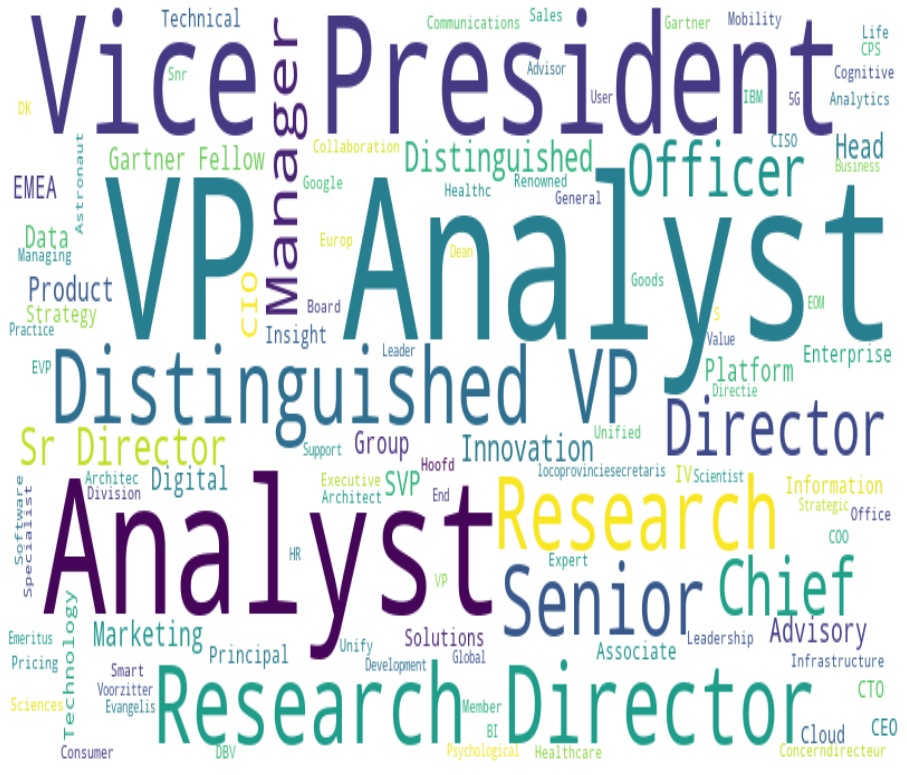

In [209]:
# wordcloud on jobTitle
from wordcloud import WordCloud # docs on WordCloud: https://amueller.github.io/word_cloud/ 
import matplotlib.pyplot as plt


# Generate a word cloud image
wordcloud = WordCloud(width=800, height=400,background_color="White").generate(jobTitlesAggregated)

    # Display the generated image:
    # the matplotlib way:
import matplotlib.pyplot as plt
plt.figure(figsize = (16,14))
plt.imshow(wordcloud, cmap=plt.cm.gray,interpolation='bilinear', aspect='auto')
plt.axis("off")
    


<a name="designation" />

## Companies for which Speakers are working
Speakers indicate the company they work for. So we can explore a little which companies are represented by speakers at these conferences. 

### Number of speakers per company
Quick evaluation of the numbers of speakers per company. Note: this is not the same as the number of sessions; that can be derived by summing the session_count per speaker

In [210]:
#other companies:
# details on value_counts: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.value_counts.html 
sp.companyName.str.upper().value_counts().head(15)

GARTNER                      85
                              3
SERVICENOW                    2
CISCO                         2
ADOBE                         2
ATOS                          2
ARLANXEO DEUTSCHLAND GMBH     1
FIRMENICH                     1
SALESFORCE                    1
BP                            1
MICROSOFT                     1
PROVINCIE ZUID HOLLAND        1
FLEXERA SOFTWARE LLC          1
ABB                           1
MCLAREN RACING                1
Name: companyName, dtype: int64

When you check the website for the Gartner IT Symposium, it is easy to find out which companies are sponsors (although they are called Thoughtleaders. But there are 26 of them. 

It is not farfetched to assume that as part of a more expensive sponsorship, companies also get a one or more slots at the conference.

## Popular First Names for Speakers
Let us investigate the hugely important question of what are the top 10 first names for the speakers.

In [211]:
# details on value_counts: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.value_counts.html 
sp['firstName'].value_counts().head(10)

Michael    5
Mark       4
John       3
Chris      3
Brian      3
Ian        2
Bill       2
Darren     2
Dave       2
Julia      2
Name: firstName, dtype: int64

<a name="gender"/>

(-0.5, 799.5, 399.5, -0.5)

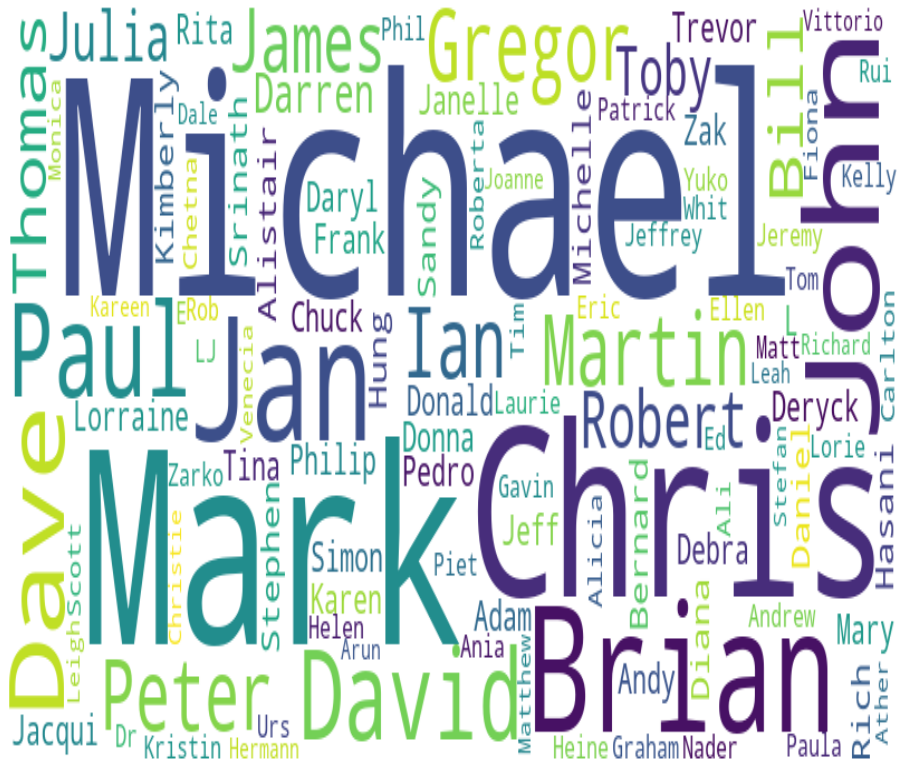

In [212]:
# create a word_cloud 
from wordcloud import WordCloud # docs on WordCloud: https://amueller.github.io/word_cloud/ 
import matplotlib.pyplot as plt

sp['dummy']='X'
firstNamesAggregated = sp.groupby(['dummy'])['firstName'].apply(','.join).reset_index().firstName[0]
del sp['dummy']

# Generate a word cloud image
wordcloud = WordCloud(width=800, height=400,background_color="White").generate(firstNamesAggregated)

    # Display the generated image:
    # the matplotlib way:
import matplotlib.pyplot as plt
plt.figure(figsize = (16,14))
plt.imshow(wordcloud, cmap=plt.cm.gray,interpolation='bilinear', aspect='auto')
plt.axis("off")

## Women in Tech - Gender of Speakers

It is interesting to know if women appear as speakers at the event - given our strive for *more women in tech*. 

We may be able to stimulate the participation of women if we better understand what type of track or topic attracts female speakers.

However: our data set does not contain ant straightforward gender information. Gender is not a feature of our speaker records. 

Does our exploration end before it event started - for lack of data? Or can we be creative? A strong indication is found in the *honorific* attribute. Perhaps, alternatively we can guess the gender from the first name feature that we do have for all speakers. Additionally, we have a biography for each speaker and in these texts speakers frequently describe themselves in the third person - using references to *he* or *she*, *his* and *him* or *her*. So we have at least three clues as to the gender of speakers. Not enough to base any important analysis or individual approach on, but it will do for this high over analysis.

### Deriving Gender from First Name

We can use an API or library for guessing the gender of the speaker based on the first name:
* https://genderize.io/ (1000 calls per day are free)
* https://gender-api.com/ - paid for
* https://pypi.org/project/gender-guesser/ - local libray
* see article for broader overview of this challenge: https://gender-gap-in-science.org/2018/07/16/telling-the-gender-from-a-name/ 


Note: in our case, we are interested in the big picture. Guessing the wrong gender in a few percent of the cases is acceptable. So let's go with the easy to use and fully free gender-guesser library.


In [213]:
import gender_guesser.detector as gender

d = gender.Detector()

def genderGuesser( name="Jan"):
    print("The Gender Guess is ",d.get_gender(name))

genderGuesser()    

The Gender Guess is  male


Let's derive a new *gender* feature for all our speakers using this library. It will not be perfect it will not be complete, but we will get a first stab at the gender distribution.

In [214]:
sp['gender'] = sp['firstName'].apply(lambda name: d.get_gender(name))
# look at some of the results
sp[['firstName','gender']][:10]

,firstName,gender
0,Donald,male
1,Daryl,mostly_male
2,Tina,female
3,Paul,male
4,Dave,male
5,Donna,female
6,Chris,mostly_male
7,David,male
8,Hung,andy
9,Brian,male


What are some of these first names that have stymied our gender guesser library?

In [215]:
sp[sp['gender']=='unknown']['firstName'][:10]

17       Deryck 
22        Rita L
36    Jan-Martin
44       Srinath
49        Hasani
67       Andrew 
77         Zarko
81            LJ
86    Carlton E.
92      Piet-Jan
Name: firstName, dtype: object

Show the gender values derived by the Gender Guesser and the numbers of instances of each:

In [216]:
# or to be more specific:
sp['gender'].value_counts(normalize=True) * 100

male             57.575758
female           18.181818
unknown          12.121212
mostly_male       6.060606
mostly_female     5.303030
andy              0.757576
Name: gender, dtype: float64

In [217]:
pd.crosstab(sp['gender'].fillna('missing'),sp['honorific'].fillna('missing'), margins=True, margins_name="Total" , dropna = False)

honorific,,Dr.,Miss,Mr,Mr.,Mrs.,Ms.,missing,Total
gender,,,,,,,,,
andy,0,0,0,0,1,0,0,0,1
female,4,0,1,0,0,0,3,16,24
male,9,0,0,1,21,0,0,45,76
mostly_female,1,1,0,0,1,1,2,1,7
mostly_male,1,0,0,0,4,0,0,3,8
unknown,4,1,0,0,1,1,0,9,16
Total,19,2,1,1,28,2,5,74,132


Can we improve our data set? 

In the next cell, we look at all biographies for the speakers with current gender values of *unknown* and *andy* to check for gender specific words such as 'his, he or him' and 'she or her' - and set those gender values based on that. 

Alternatively or additionally, we can call the gender REST APIs as listed above - if we really need our gender data to be of higher quality. Or we could try to leverage an image recognition solution powered by machine learning to classify the speaker pictures by gender.

In [218]:
#check on gender from bio for all speakers where we have not yet derived male or female

genders = ['male','female']

# this function derives gender 
def gender_guess_from_text(bio):
    
    result = "unknown"
    genderTermsToCheck = [' him ', ' his ', ' he ','His ','He ']
    # if bio contains he, his or him - we go with male
    if any(term in bio for term in genderTermsToCheck):
        result = "male"
    # if bio contains she or her - we go with female
    genderTermsToCheck = [' she ', ' her ','She','Her ']
    if any(term in bio for term in genderTermsToCheck):
        result = "female"
    # if neither - we stick to unknown
    return result

def gender_for_speaker(speaker):
    result = speaker['gender']
    # for any speaker whose gender is currently not male or female, let's try to do better
    if speaker['gender'] not in genders:
        result = gender_guess_from_text(speaker['bio']) 
    return result

sp['gender'] = sp.apply(gender_for_speaker, axis=1)

#percentages per gender based after interpreting the biographies
sp['gender'].value_counts(normalize=True) * 100


male       69.69697
female     25.00000
unknown     5.30303
Name: gender, dtype: float64

Leveraging the biographies has helped quite a bit.

With the gender derivation we have tried so far, let's see where we stand - in a Pie Chart for example.

In [219]:
pd.crosstab(sp['gender'].fillna('missing'),sp['honorific'].fillna('missing'), margins=True, margins_name="Total" , dropna = False)

honorific,,Dr.,Miss,Mr,Mr.,Mrs.,Ms.,missing,Total
gender,,,,,,,,,
female,5,1,1,0,0,2,5,19,33
male,11,1,0,1,28,0,0,51,92
unknown,3,0,0,0,0,0,0,4,7
Total,19,2,1,1,28,2,5,74,132


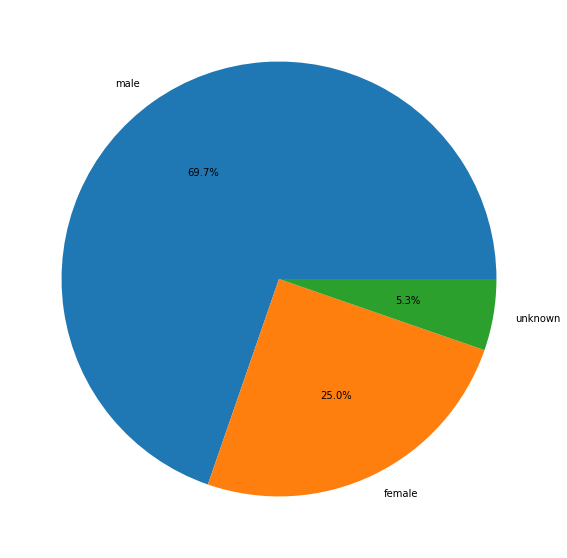

In [242]:
import matplotlib.pyplot as plt

labels = sp['gender'].value_counts(normalize=True).index
values = sp['gender'].value_counts(normalize=True).values
plt.figure(1, figsize=(20,10)) 
plt.pie(values, labels=labels, autopct='%1.1f%%')
plt.show()

One of those extremely relevant questions: do male and female speakers behave the same when it comes to uploading their photograph? 

In [222]:
# male and female are behaving the same when it comes to uploading their photograph; surprisingly, the unknown category is far more enthusiastic in sending in their picture
pd.crosstab( sp['gender'], sp['photoURL'].isnull()).apply(lambda r: 100*r/r.sum(), axis=1).round(0)

photoURL,False,True
gender,,
female,100.0,0.0
male,100.0,0.0
unknown,86.0,14.0


<a name="bonus" />

# Bonus Explorations
Below some bonus exploration of the speaker data. For example on words frequently used in speaker biographies. And on the photographs that speakers are expected to upload.

## Popular terminology in speaker Biographies
What are the words used by speakers when they craft their biographies? Can we find common themes? Typical wording? Can we learn how to write a distinctive biography for ourselves - or do we not feel any need to stand out?

(-0.5, 799.5, 399.5, -0.5)

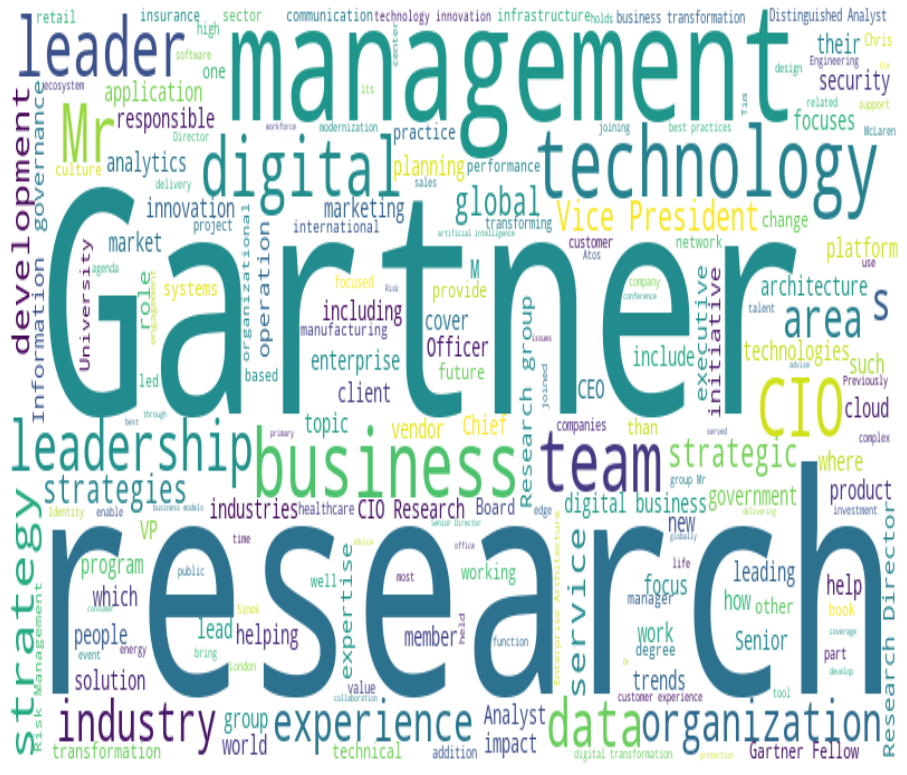

In [223]:

ENGLISH_STOP_WORDS = frozenset([
    "a", "about", "above", "across", "after", "afterwards", "again", "against",
    "all", "almost", "alone", "along", "already", "also", "although", "always",
    "am", "among", "amongst", "amoungst", "amount", "an", "and", "another",
    "any", "anyhow", "anyone", "anything", "anyway", "anywhere", "are",
    "around", "as", "at", "back", "be", "became", "because", "become",
    "becomes", "becoming", "been", "before", "beforehand", "behind", "being",
    "below", "beside", "besides", "between", "beyond", "bill", "both",
    "bottom", "but", "by", "call", "can", "cannot", "cant", "co", "con",
    "could", "couldnt", "cry", "de", "describe", "detail", "do", "done",
    "down", "due", "during", "each", "eg", "eight", "either", "eleven", "else",
    "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone",
    "everything", "everywhere", "except", "few", "fifteen", "fifty", "fill",
    "find", "fire", "first", "five", "for", "former", "formerly", "forty",
    "found", "four", "from", "front", "full", "further", "get", "give", "go",
    "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter",
    "who", "whoever", "whole", "whom", "whose", "why", "will", "with",
    "within", "without", "would", "yet", "said","you", "your", "yours", "yourself",
    "yourselves","his","he","she","of","many","the","in","to","is","on","several","com"
    ,"that","prior","more","over","it","was","currently","years","20","since"])



from wordcloud import WordCloud # docs on WordCloud: https://amueller.github.io/word_cloud/ 
import matplotlib.pyplot as plt

sp['dummy']='X'
biosAggregated = sp.groupby(['dummy'])['bio'].apply(' '.join).reset_index().bio[0]
del sp['dummy']

# Generate a word cloud image
wordcloud = WordCloud(width=800, height=400,background_color="White", stopwords=ENGLISH_STOP_WORDS ).generate(biosAggregated)

    # Display the generated image:
    # the matplotlib way:
import matplotlib.pyplot as plt
plt.figure(figsize = (16,14))
plt.imshow(wordcloud, cmap=plt.cm.gray,interpolation='bilinear', aspect='auto')
plt.axis("off")

<a name="gender"/>

## One picture and a 1000 words - Speaker Photo provided?
Each speaker is requested to upload her or his photograph. The question at hand is whether people have obliged - or could not be bothered. We will also explore the use of  pictures in a Jupyter Notebook a little.

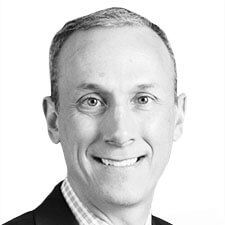

In [224]:
sp.loc[0]['photoURL']
from IPython.display import Image
Image(sp.loc[0]['photoURL'])


In [225]:
#how many speakers provided their picture/how many did not?
#this statements counts the number of null values for each column
sp.isnull().sum()

firstName             0
lastName              0
jobTitle              0
companyName           0
bio                   0
gartner_employee      0
photoURL              1
twitter             132
sessionCount          0
honorific            74
gender                0
dtype: int64

That is impressive ; only one person did not provide a photograph. Now I am curious who that was...

In [ ]:
sp[sp['photoURL'].isnull()]